In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing

from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [2]:
dataset = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')

In [3]:
dataset = dataset[dataset.price < 2000000]
#dataset = dataset.drop()

In [4]:
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
dataset['zipcode'] = dataset.zipcode.astype('str')

In [6]:
dataset = pd.get_dummies(dataset)

In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [8]:
BATCH_SIZE = 500
STEPS_PER_EPOCH = train_dataset//BATCH_SIZE

In [9]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('price')
test_labels = test_features.pop('price')

In [10]:
normalizer = preprocessing.Normalization()

In [11]:
normalizer.adapt(np.array(train_features))

In [12]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 250000])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

In [13]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(512, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
      layers.Dense(512, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss='mean_absolute_error',
                metrics=[
                  'mean_absolute_error',
                  'accuracy'])

In [14]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 460)               921       
_________________________________________________________________
dense (Dense)                (None, 512)               236032    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 500,122
Trainable params: 499,201
Non-trainable params: 921
_________________________________________________________________


In [15]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=10)

Wall time: 10.4 s


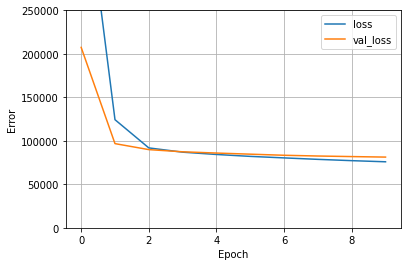

In [16]:
plot_loss(history)

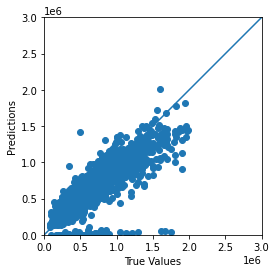

In [18]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 3000000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [23]:
dnn_model.evaluate(test_features, test_labels)

136/136 [==============================] - 0s 1ms/step - loss: 92253.5312


92253.53125

In [19]:
def root_mean_squared_error(y_true,y_pred):
        y_true = float(y_true)
        y_pred = float(y_pred)
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [20]:
df = pd.DataFrame({'predictions': test_predictions, 'actual': test_labels})
df['dif'] = df['actual']

df.dif = (df.predictions - df.actual) ** 2 / len(df)
print((df.dif.sum()) ** 0.5)
print((df.predictions[10] - df.actual[10]) ** 2)
df.head()

531611.8826570741
13649278107.515625


,predictions,actual,dif
10,779330.125000,662500.0,3.157363e+06
13,352882.375000,400000.0,5.135486e+05
19,212249.140625,230000.0,7.288758e+04
28,479183.531250,438000.0,3.923394e+05
40,582579.687500,625000.0,4.162579e+05


In [21]:
model = keras.Sequential([
    normalizer,
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.01), activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1)
])